=== SISTEMA DE DETECCIÓN DE ANOMALÍAS EN MTS ===

--- MODO ENTRENAMIENTO ---
Generando datos de entrenamiento...
Construyendo y entrenando el modelo LSTM Autoencoder...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 8)              │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 100, 8)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 8)         │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 8)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 100, 3)         │            27 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 955 (3.73 KB)

 Trainable params: 955 (3.73 KB)

 Non-trainable params: 0 (0.00 B)

2025-08-08 16:19:35.047690: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-08-08 16:19:46.085372: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

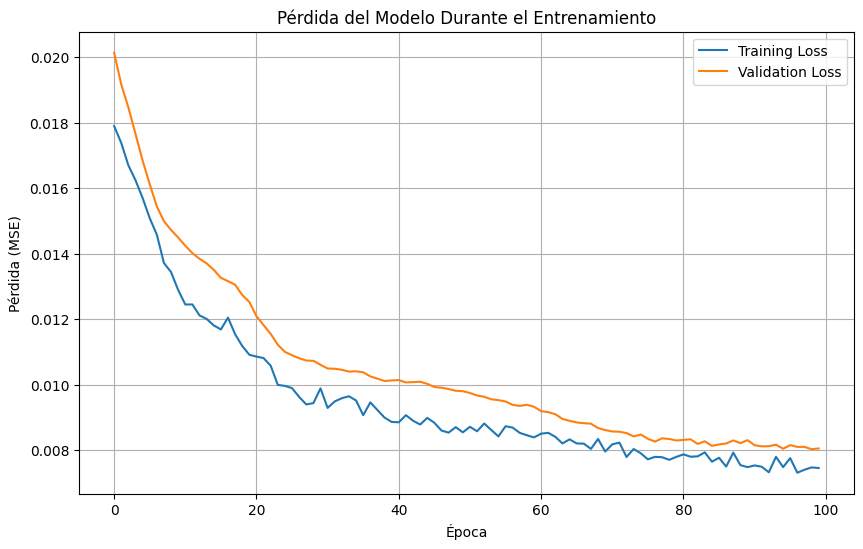

2025-08-08 16:21:18.252171: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


Artefactos guardados. Umbral: 0.027651

Generando datos de prueba...

=== EVALUACIÓN MODELO LSTM ===

--- EVALUACIÓN DE RENDIMIENTO ---
Umbral utilizado: 0.027651
Matriz de confusión:
[[81  9]
 [ 2  8]]

Reporte de clasificación:
              precision    recall  f1-score   support

  Normal (0)       0.98      0.90      0.94        90
 Anómala (1)       0.47      0.80      0.59        10

    accuracy                           0.89       100
   macro avg       0.72      0.85      0.76       100
weighted avg       0.93      0.89      0.90       100


=== ENTRENAMIENTO AGENTE RL BASE (Estado Multidimensional) ===

--- ENTRENANDO AGENTE Q-LEARNING (Características: ['max', 'std']) ---


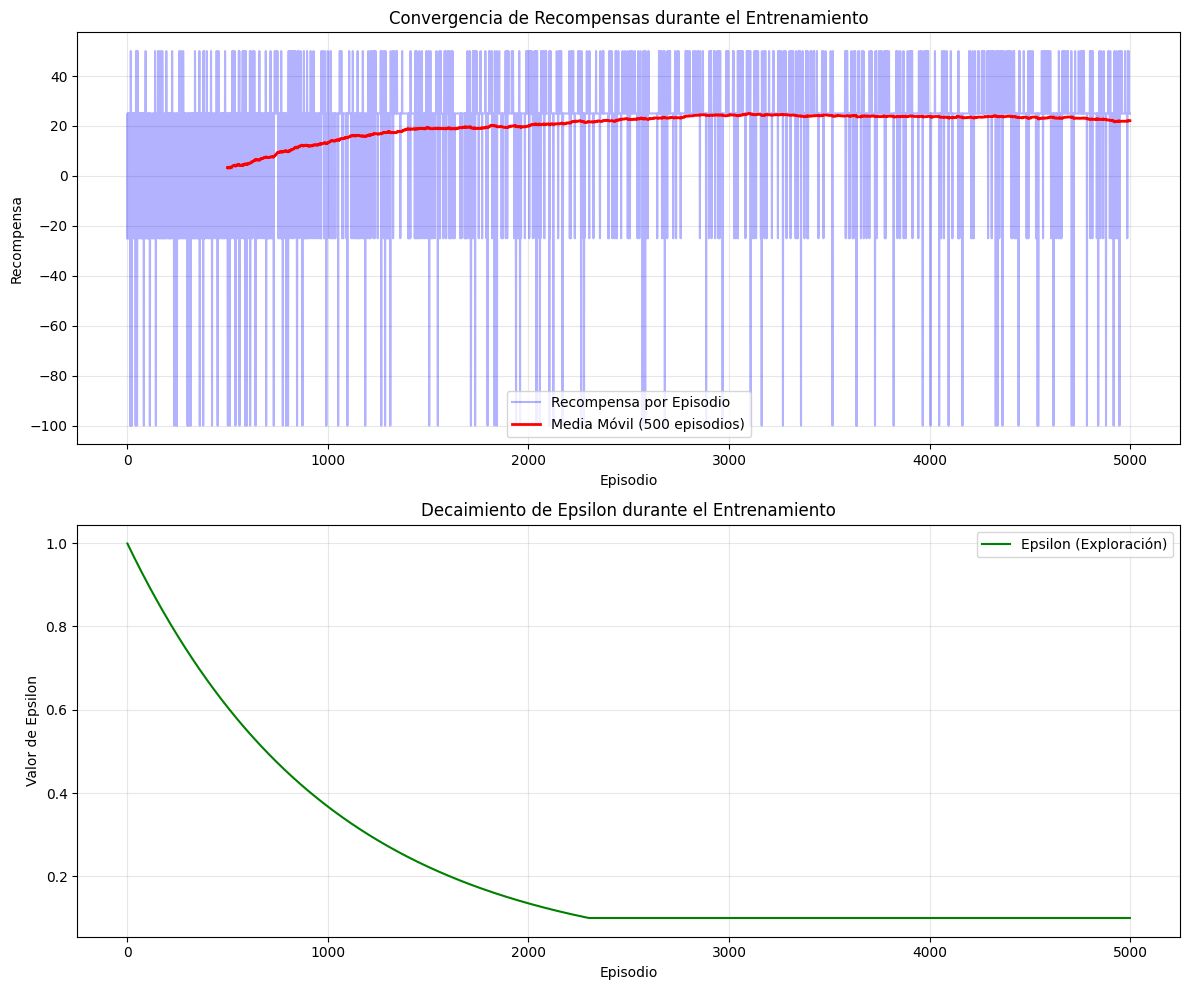


=== COMPARACIÓN FINAL DE RESULTADOS ===

1. Rendimiento LSTM (Umbral Fijo):
              precision    recall  f1-score   support

      Normal       0.98      0.90      0.94        90
     Anómala       0.47      0.80      0.59        10

    accuracy                           0.89       100
   macro avg       0.72      0.85      0.76       100
weighted avg       0.93      0.89      0.90       100


2. Rendimiento Agente RL Base (Características: ['max', 'std']):
              precision    recall  f1-score   support

      Normal       0.95      1.00      0.97        90
     Anómala       1.00      0.50      0.67        10

    accuracy                           0.95       100
   macro avg       0.97      0.75      0.82       100
weighted avg       0.95      0.95      0.94       100


=== PROCESO COMPLETADO ===


In [2]:
# ==============================================================================
# LIBRERÍAS
# ==============================================================================
import numpy as np
import pandas as pd
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import pickle
import os
import itertools
from tqdm import tqdm
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense, Dropout
from tensorflow.keras.backend import clear_session
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report

# ==============================================================================
# CONFIGURACIÓN GLOBAL
# ==============================================================================
class Config:
    """Configuración centralizada del sistema"""
    # Control de entrenamiento
    TRAIN_AUTOENCODER = True

    # Archivos del modelo
    MODEL_FILE = 'lstm_autoencoder_model.keras'
    SCALER_FILE = 'scaler.pkl'
    THRESHOLD_FILE = 'anomaly_threshold.npy'

    # Semilla para reproducibilidad
    SEED = 42

    # Parámetros de datos
    N_VARIABLES = 3
    N_SAMPLES_PER_MTS = 100
    N_MTS_TRAIN = 200
    N_MTS_TEST_NORMAL = 90
    N_MTS_TEST_ANOMALOUS = 10
    N_MTS_RL_TRAIN_NORMAL = 90
    N_MTS_RL_TRAIN_ANOMALOUS = 10

    # Parámetros del modelo
    LATENT_DIM = 8
    EPOCHS = 100
    BATCH_SIZE = 16
    VALIDATION_SPLIT = 0.1

    # Parámetros de RL
    N_EPISODES = 5000
    RL_ROLLING_WINDOW = 500
    N_STATES = 10

    # Parámetros de Grid Search para RL
    ENABLE_GRID_SEARCH = False
    PARAM_GRID = {
        # TODO: wip
    }

# ==============================================================================
# FUNCIONES DE GENERACIÓN DE DATOS
# ==============================================================================
def set_random_seeds(seed=Config.SEED):
    """Establece semillas para reproducibilidad"""
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

def generate_sinusoidal_signal(n_samples):
    """Genera una señal sinusoidal con ruido"""
    amplitude = np.random.uniform(0.5, 2.0)
    frequency = np.random.uniform(0.01, 0.05)
    phase = np.random.uniform(0, 2 * np.pi)
    t = np.arange(n_samples)
    clean_signal = amplitude * np.sin(2 * np.pi * frequency * t + phase)
    noise = np.random.normal(0, 0.1, n_samples)
    return clean_signal + noise

def generate_ramp_signal(n_samples):
    """Genera una señal de rampa con ruido"""
    slope = np.random.uniform(-0.05, 0.05)
    start = np.random.uniform(-1, 1)
    clean_signal = slope * np.arange(n_samples) + start
    noise = np.random.normal(0, 0.1, n_samples)
    return clean_signal + noise

def create_normal_mts(n_samples=Config.N_SAMPLES_PER_MTS, n_variables=Config.N_VARIABLES):
    """Crea una serie temporal multivariada normal"""
    data = {}
    signal_types = [generate_sinusoidal_signal, generate_ramp_signal]
    for i in range(n_variables):
        chosen_type = np.random.choice(signal_types)
        data[f'signal_{i}'] = chosen_type(n_samples)
    return pd.DataFrame(data)

def inject_anomalies(df):
    """Inyecta anomalías en una serie temporal"""
    anomalous_df = df.copy()
    labels = np.zeros(len(df))

    # Seleccionar columna y duración de la anomalía
    anomalous_column = np.random.choice(df.columns)
    anomaly_duration = np.random.randint(2, 5)
    start_idx = np.random.randint(0, len(df) - anomaly_duration) if len(df) > anomaly_duration else 0
    anomaly_indices = range(start_idx, start_idx + anomaly_duration)
    labels[anomaly_indices] = 1

    # Crear valor anómalo
    mean_val = df[anomalous_column].mean()
    std_val = df[anomalous_column].std()
    anomalous_value = mean_val + (8 * (std_val if std_val > 0 else 1) * np.random.choice([-1, 1]))
    anomalous_df.loc[anomaly_indices, anomalous_column] = anomalous_value

    return anomalous_df, labels

def generate_dataset(n_normal, n_anomalous):
    """Genera un conjunto de datos completo"""
    dataset = []
    labels = []
    sample_labels = []

    # Generar series normales
    for _ in range(n_normal):
        dataset.append(create_normal_mts())
        labels.append(0)
        sample_labels.append(np.zeros(Config.N_SAMPLES_PER_MTS))

    # Generar series anómalas
    for _ in range(n_anomalous):
        anomalous_df, anomaly_labels = inject_anomalies(create_normal_mts())
        dataset.append(anomalous_df)
        labels.append(1)
        sample_labels.append(anomaly_labels)

    return dataset, np.array(labels), np.array(sample_labels, dtype=object)

def preprocess_data(data_np, scaler=None):
    """Preprocesa los datos aplicando normalización"""
    n_samples, n_steps, n_features = data_np.shape
    data_flat = data_np.reshape((n_samples * n_steps, n_features))

    if scaler is None:
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data_flat = scaler.fit_transform(data_flat)
        return scaled_data_flat.reshape(data_np.shape), scaler
    else:
        scaled_data_flat = scaler.transform(data_flat)
        return scaled_data_flat.reshape(data_np.shape)

# ==============================================================================
# FUNCIONES DEL MODELO LSTM AUTOENCODER
# ==============================================================================
def build_lstm_autoencoder():
    """Construye el modelo LSTM Autoencoder"""
    clear_session()
    inputs = Input(shape=(Config.N_SAMPLES_PER_MTS, Config.N_VARIABLES))

    # Codificador
    encoder = LSTM(Config.LATENT_DIM, activation='tanh')(inputs)
    encoder = Dropout(0.1)(encoder)

    # Decodificador
    decoder = RepeatVector(Config.N_SAMPLES_PER_MTS)(encoder)
    decoder = LSTM(Config.LATENT_DIM, activation='tanh', return_sequences=True)(decoder)
    decoder = Dropout(0.1)(decoder)
    outputs = TimeDistributed(Dense(Config.N_VARIABLES, activation='sigmoid'))(decoder)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

def train_model(X_train_scaled):
    """Entrena el modelo LSTM Autoencoder"""
    print("Construyendo y entrenando el modelo LSTM Autoencoder...")
    model = build_lstm_autoencoder()
    model.summary()

    # Entrenar el modelo
    history = model.fit(
        X_train_scaled, X_train_scaled,
        epochs=Config.EPOCHS,
        batch_size=Config.BATCH_SIZE,
        validation_split=Config.VALIDATION_SPLIT,
        verbose=0,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min')]
    )

    # Mostrar curvas de aprendizaje
    plot_training_curves(history)

    return model, history

def calculate_threshold(model, X_train_scaled):
    """Calcula el umbral de anomalía basado en el percentil 99.5"""
    reconstructions = model.predict(X_train_scaled, verbose=0)
    train_loss = tf.keras.losses.mse(reconstructions, X_train_scaled)
    threshold = np.percentile(train_loss, 99.5)
    return threshold

def save_model_artifacts(model, scaler, threshold):
    """Guarda el modelo, el escalador y el umbral"""
    model.save(Config.MODEL_FILE)
    with open(Config.SCALER_FILE, 'wb') as f:
        pickle.dump(scaler, f)
    np.save(Config.THRESHOLD_FILE, threshold)
    print(f"Artefactos guardados. Umbral: {threshold:.6f}")

def load_model_artifacts():
    """Carga el modelo, el escalador y el umbral"""
    if not all([os.path.exists(f) for f in [Config.MODEL_FILE, Config.SCALER_FILE, Config.THRESHOLD_FILE]]):
        raise FileNotFoundError("Archivos del modelo no encontrados. Ejecuta con TRAIN_AUTOENCODER = True primero.")

    model = load_model(Config.MODEL_FILE)
    with open(Config.SCALER_FILE, 'rb') as f:
        scaler = pickle.load(f)
    threshold = np.load(Config.THRESHOLD_FILE)

    return model, scaler, threshold

# ==============================================================================
# FUNCIONES DE EVALUACIÓN Y VISUALIZACIÓN
# ==============================================================================
def evaluate_model_performance(model, X_test_scaled, y_true, threshold):
    """Evalúa el rendimiento del modelo"""
    print("\n--- EVALUACIÓN DE RENDIMIENTO ---")
    reconstructions = model.predict(X_test_scaled, verbose=0)
    anomaly_curves = tf.keras.losses.mse(reconstructions, X_test_scaled)
    y_pred = np.any(anomaly_curves > threshold, axis=1).astype(int)

    print(f"Umbral utilizado: {threshold:.6f}")
    print("Matriz de confusión:")
    print(confusion_matrix(y_true, y_pred))
    print("\nReporte de clasificación:")
    print(classification_report(y_true, y_pred, target_names=['Normal (0)', 'Anómala (1)']))

    return y_pred, anomaly_curves

def plot_training_curves(history):
    """Grafica las curvas de entrenamiento"""
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Pérdida del Modelo Durante el Entrenamiento')
    plt.xlabel('Época')
    plt.ylabel('Pérdida (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

def visualize_mts_with_anomaly_curve(df, anomaly_curve, threshold, title):
    """Visualiza una serie temporal con su curva de anomalía"""
    n_vars = df.shape[1]
    fig, axes = plt.subplots(n_vars + 1, 1, figsize=(14, 2.5 * (n_vars + 1)), sharex=True)
    fig.suptitle(title, fontsize=14)

    # Graficar cada variable
    for i, column in enumerate(df.columns):
        axes[i].plot(df.index, df[column], label=f'Valores de {column}', color=f'C{i}')
        axes[i].set_title(column)
        axes[i].set_ylabel('Valor')
        axes[i].grid(True, alpha=0.3)
        axes[i].legend()

    # Graficar curva de anomalía
    axes[-1].plot(df.index, anomaly_curve, color='purple', label='Puntuación de Anomalía (MSE)')
    if threshold is not None:
        axes[-1].axhline(y=threshold, color='red', linestyle='--', lw=2, label=f'Umbral ({threshold:.4f})')
    axes[-1].set_title('Curva de Puntuación de Anomalía')
    axes[-1].set_xlabel('Muestras')
    axes[-1].set_ylabel('Error (MSE)')
    axes[-1].legend()
    axes[-1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# ==============================================================================
# CLASE Y FUNCIONES DEL AGENTE Q-LEARNING
# ==============================================================================
class QLearningAgent:
    """Agente de Q-Learning para detección de anomalías con estado multidimensional"""

    def __init__(self, n_states, n_actions, learning_rate=0.1, epsilon=1.0,
                 epsilon_decay=0.999, epsilon_min=0.1, state_features=['max', 'std']):
        self.n_states = n_states
        self.n_actions = n_actions
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.state_features = state_features
        self.n_features = len(state_features)

        # Q-table multidimensional: cada dimensión del estado tiene n_states posibles valores
        # Total de estados = n_states^n_features
        total_states = n_states ** self.n_features
        self.q_table = np.zeros((total_states, n_actions))

    def extract_features_from_curve(self, anomaly_curve):
        """Extrae múltiples características de la curva de anomalía"""
        features = {}
        features['max'] = np.max(anomaly_curve)
        features['mean'] = np.mean(anomaly_curve)
        features['std'] = np.std(anomaly_curve)
        features['median'] = np.median(anomaly_curve)
        features['range'] = np.max(anomaly_curve) - np.min(anomaly_curve)
        features['var'] = np.var(anomaly_curve)

        return features

    def discretize_multidimensional_state(self, anomaly_curve, feature_bins):
        """Discretiza múltiples características en un estado multidimensional"""
        features = self.extract_features_from_curve(anomaly_curve)

        # Discretizar cada característica
        discrete_states = []
        for feature_name in self.state_features:
            if feature_name in features and feature_name in feature_bins:
                bins = feature_bins[feature_name]
                # Asegurarse de que los bins estén ordenados correctamente y manejar casos extremos
                if len(bins) > 1:
                    discrete_value = np.digitize(features[feature_name], bins[1:])
                    discrete_value = max(0, min(discrete_value, self.n_states - 1))
                    discrete_states.append(discrete_value)
                else:
                    discrete_states.append(0)
            else:
                # Valor predeterminado si la característica no existe o faltan bins
                discrete_states.append(0)

        # Convertir estado multidimensional a índice único
        state_index = 0
        for i, state_val in enumerate(discrete_states):
            state_index += state_val * (self.n_states ** i)

        return state_index

    def choose_action(self, state, explore=True):
        """Elige una acción usando epsilon-greedy"""
        if explore and np.random.rand() < self.epsilon:
            return np.random.choice(self.n_actions)
        else:
            return np.argmax(self.q_table[state, :])

    def update_q_table(self, state, action, reward):
        """Actualiza la tabla Q"""
        old_value = self.q_table[state, action]
        new_value = old_value + self.learning_rate * (reward - old_value)
        self.q_table[state, action] = new_value

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

def create_feature_bins(anomaly_curves, n_states, state_features):
    """Crea bins para discretizar cada característica del estado"""
    feature_bins = {}

    for feature_name in state_features:
        feature_values = []
        for curve in anomaly_curves:
            agent_temp = QLearningAgent(n_states, 2, state_features=[feature_name])
            features = agent_temp.extract_features_from_curve(curve)
            if feature_name in features:
                feature_values.append(features[feature_name])

        if feature_values:
            feature_values = np.array(feature_values)
            # Manejar casos donde el mínimo y el máximo son iguales
            if np.isclose(feature_values.min(), feature_values.max()):
                bins = np.array([feature_values.min()]) # Bin único
            else:
                bins = np.linspace(feature_values.min(), feature_values.max(), n_states)
            feature_bins[feature_name] = bins
        else:
            # Bins predeterminados si no se encuentran valores de características
            feature_bins[feature_name] = np.linspace(0, 1, n_states)

    return feature_bins

def get_reward(true_label, predicted_action, reward_scheme=None):
    """Calcula la recompensa basada en la predicción"""
    if reward_scheme is None:
        reward_scheme = {'tp': 50, 'tn': 25, 'fp': -25, 'fn': -100}

    if predicted_action == 1 and true_label == 1:  # Verdadero Positivo
        return reward_scheme['tp']
    elif predicted_action == 0 and true_label == 0:  # Verdadero Negativo
        return reward_scheme['tn']
    elif predicted_action == 1 and true_label == 0:  # Falso Positivo
        return reward_scheme['fp']
    elif predicted_action == 0 and true_label == 1:  # Falso Negativo
        return reward_scheme['fn']
    return 0

def train_rl_agent_single(model, scaler, learning_rate=0.1, epsilon_decay=0.999,
                         n_states=None, reward_scheme=None, n_episodes=None,
                         state_features=['max', 'std']):
    """Entrena un solo agente de Q-Learning con parámetros específicos y estado multidimensional"""
    n_states_to_use = n_states if n_states is not None else Config.N_STATES
    n_episodes_to_use = n_episodes if n_episodes is not None else Config.N_EPISODES
    reward_scheme_to_use = reward_scheme if reward_scheme is not None else {'name': 'Balanced', 'tp': 50, 'tn': 25, 'fp': -25, 'fn': -100}

    # Generar datos de entrenamiento para RL
    train_dataset, y_true_train, _ = generate_dataset(
        Config.N_MTS_RL_TRAIN_NORMAL,
        Config.N_MTS_RL_TRAIN_ANOMALOUS
    )

    X_train = np.array([df.values for df in train_dataset])
    X_train_scaled = preprocess_data(X_train, scaler)

    # Calcular curvas de anomalía completas
    reconstructions = model.predict(X_train_scaled, verbose=0)
    anomaly_curves = tf.keras.losses.mse(reconstructions, X_train_scaled)

    # Crear bins para las características seleccionadas
    feature_bins = create_feature_bins(anomaly_curves, n_states_to_use, state_features)

    # Configurar agente con estado multidimensional
    agent = QLearningAgent(n_states=n_states_to_use, n_actions=2,
                          learning_rate=learning_rate, epsilon_decay=epsilon_decay,
                          state_features=state_features)

    # Entrenar agente
    rewards_per_episode = []
    epsilon_per_episode = []

    for episode in range(n_episodes_to_use):
        idx = np.random.randint(len(anomaly_curves))
        anomaly_curve = anomaly_curves[idx]
        true_label = y_true_train[idx]

        state = agent.discretize_multidimensional_state(anomaly_curve, feature_bins)
        action = agent.choose_action(state, explore=True)
        reward = get_reward(true_label, action, reward_scheme_to_use)
        agent.update_q_table(state, action, reward)

        rewards_per_episode.append(reward)
        epsilon_per_episode.append(agent.epsilon)

    return agent, feature_bins, rewards_per_episode, epsilon_per_episode

def train_rl_agent(model, scaler, state_features=['max', 'std']):
    """Entrena el agente de Q-Learning con parámetros por defecto"""
    print(f"\n--- ENTRENANDO AGENTE Q-LEARNING (Características: {state_features}) ---")
    agent, feature_bins, rewards_per_episode, epsilon_per_episode = train_rl_agent_single(
        model, scaler, state_features=state_features
    )

    # Mostrar análisis de entrenamiento
    plot_rl_training_progress(rewards_per_episode, epsilon_per_episode)

    return agent, feature_bins

def plot_rl_training_progress(rewards_per_episode, epsilon_per_episode):
    """Grafica el progreso del entrenamiento del agente RL"""

    # Crear figura con 2 subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Gráfico de convergencia de recompensas
    moving_avg = pd.Series(rewards_per_episode).rolling(window=Config.RL_ROLLING_WINDOW).mean()

    ax1.plot(rewards_per_episode, label='Recompensa por Episodio', alpha=0.3, color='blue')
    ax1.plot(moving_avg, label=f'Media Móvil ({Config.RL_ROLLING_WINDOW} episodios)', color='red', linewidth=2)
    ax1.set_title('Convergencia de Recompensas durante el Entrenamiento')
    ax1.set_xlabel('Episodio')
    ax1.set_ylabel('Recompensa')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Gráfico de decaimiento de epsilon
    ax2.plot(epsilon_per_episode, label='Epsilon (Exploración)', color='green', linewidth=1.5)
    ax2.set_title('Decaimiento de Epsilon durante el Entrenamiento')
    ax2.set_xlabel('Episodio')
    ax2.set_ylabel('Valor de Epsilon')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# ==============================================================================
# FUNCIÓN PRINCIPAL
# ==============================================================================
def main():
    """Función principal que ejecuta todo el pipeline"""
    print("=== SISTEMA DE DETECCIÓN DE ANOMALÍAS EN MTS ===")

    # Configurar semillas para reproducibilidad
    set_random_seeds()

    if Config.TRAIN_AUTOENCODER:
        print("\n--- MODO ENTRENAMIENTO ---")

        # Generar datos de entrenamiento
        print("Generando datos de entrenamiento...")
        train_dataset, _, _ = generate_dataset(Config.N_MTS_TRAIN, 0)
        X_train = np.array([df.values for df in train_dataset])
        X_train_scaled, scaler = preprocess_data(X_train)

        # Entrenar modelo
        model, history = train_model(X_train_scaled)

        # Calcular umbral y guardar artefactos
        threshold = calculate_threshold(model, X_train_scaled)
        save_model_artifacts(model, scaler, threshold)

    else:
        print("\n--- MODO PREDICCIÓN ---")
        try:
            model, scaler, threshold = load_model_artifacts()
            print(f"Modelo cargado. Umbral: {threshold:.6f}")
        except FileNotFoundError as e:
            print(f"Error: {e}")
            return

    # Generar datos de prueba
    print("\nGenerando datos de prueba...")
    test_dataset, y_true_test, y_sample_labels = generate_dataset(
        Config.N_MTS_TEST_NORMAL,
        Config.N_MTS_TEST_ANOMALOUS
    )

    X_test = np.array([df.values for df in test_dataset])
    X_test_scaled = preprocess_data(X_test, scaler)

    # Evaluar modelo LSTM
    print("\n=== EVALUACIÓN MODELO LSTM ===")
    y_pred_lstm, anomaly_curves = evaluate_model_performance(model, X_test_scaled, y_true_test, threshold)

    # Entrenar agente RL base con estado multidimensional
    print("\n=== ENTRENAMIENTO AGENTE RL BASE (Estado Multidimensional) ===")
    state_features_base = ['max', 'std']
    base_agent, base_feature_bins = train_rl_agent(model, scaler, state_features=state_features_base)

    # Evaluar agente base
    y_pred_rl_base = []
    for curve in anomaly_curves:
        state = base_agent.discretize_multidimensional_state(curve, base_feature_bins)
        action = base_agent.choose_action(state, explore=False)
        y_pred_rl_base.append(action)
    y_pred_rl_base = np.array(y_pred_rl_base)

    # Grid Search
    best_agent = None
    best_feature_bins = None
    best_params = None
    y_pred_rl_best = None

    if Config.ENABLE_GRID_SEARCH:
        pass
        # TODO: wip
    else:
        best_agent = base_agent
        best_feature_bins = base_feature_bins
        best_params = {"state_features": state_features_base, "note": "Parámetros por defecto (Grid Search deshabilitado)"}
        y_pred_rl_best = y_pred_rl_base


    # Comparar todos los resultados
    print("\n=== COMPARACIÓN FINAL DE RESULTADOS ===")

    print("\n1. Rendimiento LSTM (Umbral Fijo):")
    print(classification_report(y_true_test, y_pred_lstm, target_names=['Normal', 'Anómala']))

    print(f"\n2. Rendimiento Agente RL Base (Características: {state_features_base}):")
    print(classification_report(y_true_test, y_pred_rl_base, target_names=['Normal', 'Anómala']))

    print("\n=== PROCESO COMPLETADO ===")


# ==============================================================================
# EJECUCIÓN
# ==============================================================================
if __name__ == "__main__":
    main()